# Speech Commands Recongition

Ziye Xing<br>
University of California, Los Angeles<br>
xingziye@cs.ucla.edu

Nowadays Automatics Speech Recognition is important for many applications since it is widely used as a portal for human-computer interaction. One of the most popular applications in ASR is to recognize single word commands for versatile tasks, as most of them can be easily invoked by a single word command, and they will serve as entrance points for many suitable tasks. The key for a successful implementation of this application is to have a high recognition accuracy for those finite number of words in command set. In other words, by giving a set of valid commands and a record of a speech, we want to predict what the most possible command this record of speech mean to be. In this project, an isolated word speech command detector model will be built based on neural networks, to help recognize and classify the records of speech commands.

## Introduction

Speech identification is not a new field in computer science. Since late 1950s, there has been researches developing techniques for identify isolated digits or continuous speech. For traditional speech recognition methods, the most common and conventional system use Gaussian Mixture Model based on Hidden Markov Model (GMM-HMM) to try capturing the sequential structure of speech signals. The speech signal can be viewed as an observation of the temporal dynamics of speech, while each state has an emission of local stationary speech. A mixture of Gaussian distribution is utilized to model a spectral representation of the sound wave to identify the acoustic components.

Due to the limitation of Markov assumption itself and its statistical inefficiency, there are challenges for this conventional model to get further improvement. After HMM-GMM being used for many years, People start to move their attention to Neural Networks. In the project, I will mostly focus on the application on those neural networks and compare their results. As the traditional Automatics Speech Recognition has become a huge topic where so many tedious details to be considered, people move towards the end-to-end solution as well recently. Also, in this project we are only interested in isolated words recognition, which is a lot simplified problem of ASR. Many bottlenecks in continuous speech recognition does not exist and the isolated word recognition potentially has its own specific solution.

In the Speech Commands Datasets released by TensorFlow recently, 65,000 one-second long utterances of 30 short words are collected, from thousands of different sources including women, men, children, and the old. Google supports this challenge and present it on Kaggle website for public competition. In this challenge, only 12 possible labels will be used in the test set:
```python
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
```
For the rest of labels that are not in the legal labels set, they should be classified as `unknow` label.

In the following section, the acoustic models used in this project will be introduced. Also, the preprocessing process of the audio signal will also be covered. Lastly, the experiment result and analysis will be presented.

## Feature Extraction

Although the purely end-to-end solutions are possible and promising, it usually takes too much computational resource for wave signals as input. In traditional ASR configuration, it is conventional to preprocessing the signals or extract features that have lower dimension for training. Also, some properties of the records determinate they can be resampled in lower band to reduce the dimensionality.

Most of the records in the training set are sampled in 16k Hz sample rate. However, most human speech voice frequencies are in lower band, a typical adult have a fundamental frequency from 85 to 255 Hz. Here we will try to resample our signal into 8k Hz instead to reduce dimensionality. This could be done using Fast Fourier Transform and remove components in high band.

In [10]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob

import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

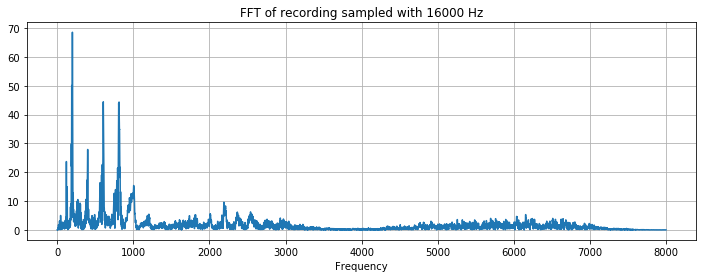

In [12]:
filename = '00f0204f_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

ipd.Audio(samples, rate=sample_rate)

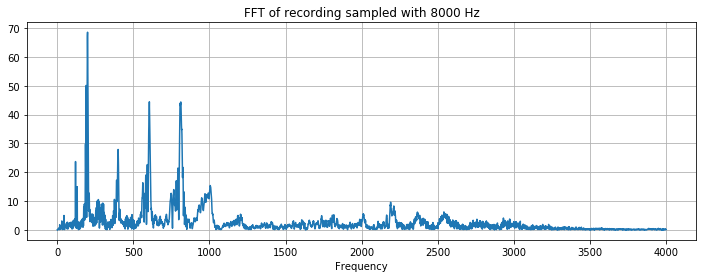

In [13]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

ipd.Audio(resampled, rate=new_sample_rate)

As you can see, after resampling, the high frequency components are removed, but the sound does not change much. We as a human being can still easily recognize the word utterance.

Another common feature for audio wave is spectrogram. The spectrogram tries to split the audio wave into several larger frames by some window size, then compute the frequency components in the window of frames. Then we move to the next window overlapping with or without the previous one. One window after another, we shall get a graph showing the frequency components along time line.

In [14]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5,0,'Seconds')

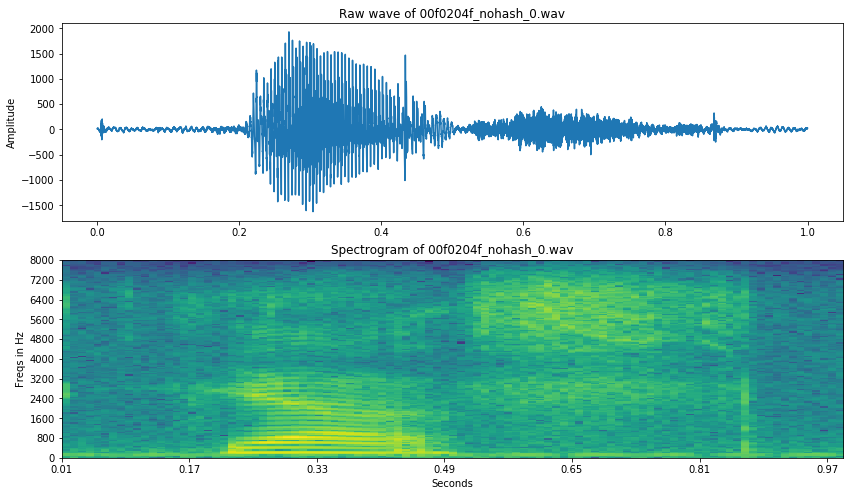

In [15]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In the raw wave from the upper graph, we can make a good guess that the first half part with wide amplitude range is the /ye/ part, the second half is the /s/ sound. We can clearly see that in the corresponding spectrogram, /ye/ sound mostly are low frequency components and /s/ sound has higher frequency. Now, instead of classifying a sound wave, we are dealing with the spectrum of frequency just like an image. Thus, Convolution Neural Network could play a significant role in the classification.

There are also other common features, such as Mel Frequency Cepstral Coefficient (MFCC), used in ASR. MFCC are considered as state-of-art feature extraction technique in the traditional HMM method. It is similar to spectrogram, but it is better capturing and identifying the linguistic content, discarding all other useless features, such as emotion and background noise. In this project, up until current stage, only the spectrogram is used for the Neural Network input, as we could have a change the Neurons could figure out the pattern by themselves.

## Acoustic Model

Although the traditional ASR methods are not examined in this project, it is worthwhile to take some time to review its acoustic model. The input audio will be converted into a sequence of fixed size vector $Y=[y_1,...,y_t]$. Vectors are generally features extracted by using the techniques introduced above. Then a decoder attempts to find the word $W$ which maximizes the probability given $Y$ for all possible words:
$$\hat{W}=argmax_WP(W|Y)$$
According to Bayes’ Rule, it is equivalate to:
$$\hat{W}=argmax_W[P(Y|W)P(W)]$$

Then for the first part, we can apply acoustic model such as HMM to modeling the sequence of pronunciation and phonemes. While the second part is a language model, which is outside content of this discuss, usually adopts n-gram model that is working fine.

In the context of Neural Network, let a single utterance $x$ and label $y$ be sampled from a training set $X = \{(x^{(1)}, y^{(1)}),(x^{(2)}, y^{(2)}),...\}$. Each input $x$ is a series of vectors of feature extracted through the methods introduced above. As we used spectrograms as our features, $x_{t,p}^{(t)}$ denoted the amplitude of the $p$'th frequency range at time t. For the output space, we want to find a optimal $y$, with $\hat{y_t} = p(c_t|x)$, where $c_t\in\{yes, no, up, down, left, right, on, off, stop, go, silence, unknown\}$.
In the experiment, we will see diffident combination of layers being used for testing. Both Convolutional Neural Network and Recurrent Neural Network have been tested. For non-recurrent layers, the general form of equation is computed by:
$$h^{(l)}_t = g(W^{(l)}h^{(l−1)}_t + b^{(l)})$$
Where $h$ denotes the hidden units of each layer. For recurrent layer, the equation has the following form
$$h^{(l)}_t = g(W^{(1)}h^{(0)}_t + W^{(l)}h^{(l−1)}_t + b^{(1)})$$
Lastly, the output layer is a standard softmax function to predict the probability of each unit in output space. We also use categorical crossentropy as the loss function since the output space is discrete. 


## Experiment

In the experiment, we will investigate the performance of both CNN and RNN models for this Speech Recognition task. Before we can train our models, we shall first look through the training data we have. There are more than 64k audio files in training set. They are organized in different folder collections, wave files in one folder have the same utterance label. There is also a special category where the background noises are stored in `_background_noise_` folder. The numbers of files in each category are shown in the following graph.

![Number of recordings in given label](newplot.png "Number of recordings in given label")

Most files are evenly distributed into different categories, except there are only few files in background noise folder. However, the files in background noise folder are much longer than other clips. We shall consider break those noise record into multiple 1 second clips for the training purpose. Furthermore, the file names are not unique globally, the first part separated by underscore in the file name is a unique code for speaker, where the third part denotes the number of time this word spoken by this speaker so far.

Conceptually, Recurrent Neural Network is designed for sequences input, especially those with temporal structure. In our case, the spectrogram also has a time-sliced structure embedding, it is natural to consider RNN for our first try in the training process. As we know Convolutional Neural Network is known for a robust image classifier, and since we use spectrogram as our input vectors, it is also suitable for convolutional layer to capture the transitions in the graphs. I would also be a decent choice for spectrogram input features.

We use Keras as our library for network construction, it is built upon the TensorFlow architecture and provide higher level API for concise usage. The models have been training locally on the desktop computer with a GTX 1060 GPU enabled. The following table shows the best validation accuracy achieved and its performance in test set prediction.

| Model        | Val_Accuracy   | Test_Accuracy |
| :---         |     ---        |          ---: |
| LSTM-1layer  | 0.8695         | 0.55      |
| GRU-1layer   | 0.9086         | 0.63      |
| GRU-3layer   | 0.9459         | 0.71      |
| CNN-8k       | 0.9266         | 0.74      |
| CNN-16k      | 0.9582         | 0.80      |

According to the experiment results, CNN outperformed RNN architecture by using spectrogram as input features. One possible reason that RNN does not return promising result is that during the calculation of spectrogram, the window of frames has mixture with information close to the frame. The number after CNN indicates the sample rate used in the original wave file. The best performance generates 80% accuracy in the test dataset. Comparing with the 1st place on the public leader board of Kaggle website who has 89% accuracy currently, this model could potentially be further improved by tuning hyper-parameters including kernel size and number of layers, etc.

![Loss over time](loss.png "Loss over time")

The image above shows the loss of CNN with 16k sample rate during training process. The model converges well during the training. Besides that we can see there are still potential improvement if we train the model with more iterations and decay the learning rate based on the iteration times.

## Conclusion

In this project, Recurrent and Convolutional Neural Network are applied to this Speech Commands Recognition challenge. The result shows promising result for both CNN and RNN architecture applied. The best performance achieved so far can predict 80% of recording correctly. We can try to tune more hyper-parameter to further improve our model, or an end-to-end solution is also possible to product even better result. For this experiment particularly, another trick we can try is to predict all 30 possible labels and then replace the illegal label to unknown afterward. In general, Neural Network and end-to-end solution have shown their capability in many tasks and applications. It is believed that with the further researches investigated, we can achieve a seamless interaction for human and machine that speech and language can be fully understand by computer in future.


## Reference
- "Warden P. Speech Commands: A public dataset for single-word speech recognition, 2017. Available from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz".
- DavidS, [Speech representation and data exploration](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration)
- BingQing Wei, [Light-Weight CNN LB 0.74](https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74)
- Hannun, A., Case, C., Casper, J., Catanzaro, B., Diamos, G., Elsen, E., ... & Ng, A. Y. (2014). Deep speech: Scaling up end-to-end speech recognition. arXiv preprint arXiv:1412.5567.
- Dhanashri, D., & Dhonde, S. B. (2017). Isolated Word Speech Recognition System Using Deep Neural Networks. In Proceedings of the International Conference on Data Engineering and Communication Technology (pp. 9-17). Springer Singapore.
- Yan Zhang, Speech Recognition Using Deep Learning Algorithms